In [1]:
############ Only Run if you're using google drive for your datafiles and working directory #############
############ Otherwise no need to run if everything is in the colab top level directory #################
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import os

###### Change to your working directory
os.chdir(os.curdir + "/drive/My Drive/Colab Notebooks/2024 Fall/NSF HDR ML Challenge/")

Mounted at /content/drive/


In [ ]:
# Let's start with necessary imports
import os
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [ ]:
# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load background data
background = np.load('background.npz')['data']

# Compute global mean and std over all samples and time steps
global_mean = np.mean(background, axis=(0, 2), keepdims=True)
global_std = np.std(background, axis=(0, 2), keepdims=True)

# Normalize background using the global statistics
background = (background - global_mean) / (global_std + 1e-12)

# Similarly load and normalize the BBH and SGLF data using the same global mean and std
bbh = np.load('bbh_for_challenge.npy')
bbh = (bbh - global_mean) / (global_std + 1e-12)

sglf = np.load('sglf_for_challenge.npy')
sglf = (sglf - global_mean) / (global_std + 1e-12)

# Swap axes for the models
background = np.swapaxes(background, 1, 2)
bbh = np.swapaxes(bbh, 1, 2)
sglf = np.swapaxes(sglf, 1, 2)

In [ ]:
# Create train and test datasets
x_train, x_test, _, _ = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
# print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 200, 2) (20000, 200, 2)


In [ ]:
@keras.utils.register_keras_serializable(package="Custom")
class SinusoidalPositionalEncoding(layers.Layer):
    """Fixed sinusoidal positional encoding."""
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, x):
        # x shape: (batch, time, channels)
        length = tf.shape(x)[1]
        d_model = tf.shape(x)[2]
        position = tf.cast(tf.range(length)[:, tf.newaxis], tf.float32)
        div_term = tf.exp(tf.range(0, d_model, 2, dtype=tf.float32) * (-np.log(10000.0) / tf.cast(d_model, tf.float32)))
        sin_pos = tf.sin(position * div_term)
        cos_pos = tf.cos(position * div_term)
        # Interleave sine and cosine
        pos_encoding = tf.reshape(tf.stack([sin_pos, cos_pos], axis=-1), (length, d_model))
        return x + pos_encoding[tf.newaxis, ...]
    def get_config(self):
        return super().get_config()

In [ ]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0, l2_reg=0.0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout,
            kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None,
            bias_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu",
                          kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1,
                          kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0, l2_reg=0.0):
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu",
                         kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim, kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(x)

        x = layers.Dense(ff_dim, activation="relu",
                         kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu",
                         kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]),
                         kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0.2, l2_reg=0.0):
        inputs = keras.Input(shape=input_shape)

        # Use SinusoidalPositionalEncoding instead of trainable embedding
        x = SinusoidalPositionalEncoding()(inputs)

        # Encoder (Transformer blocks)
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_reg=l2_reg)

        # Decoder (Dense blocks)
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout, l2_reg=l2_reg)

        # Output layer
        outputs = layers.Dense(input_shape[-1], kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None)(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))


    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(
            os.path.join(os.path.dirname(__file__), 'model.keras'),
            custom_objects={"SinusoidalPositionalEncoding": SinusoidalPositionalEncoding}
        )

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Initialize the model
input_shape = x_train.shape[1:]
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=64,
    num_heads=2,
    ff_dim=64,
    num_transformer_blocks=4,
    num_dense_blocks=2,
    dropout=0.2,
    l2_reg=1e-6
)

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss')
]

history = autoencoder.fit(
    x_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 28ms/step - loss: 3.9211 - val_loss: 1.9368 - learning_rate: 1.0000e-04
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 2.1379 - val_loss: 1.4024 - learning_rate: 1.0000e-04
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 1.6040 - val_loss: 1.0296 - learning_rate: 1.0000e-04
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 1.2800 - val_loss: 0.8696 - learning_rate: 1.0000e-04
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 1.1057 - val_loss: 0.7490 - learning_rate: 1.0000e-04
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.9955 - val_loss: 0.6952 - learning_rate: 1.0000e-04
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.9261 - val_loss: 0.6555 - learning_rate: 1.0000e-04
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.8892 - val_loss: 0.6261 - learning_rate: 1.0000e-04
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 2

In [ ]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')

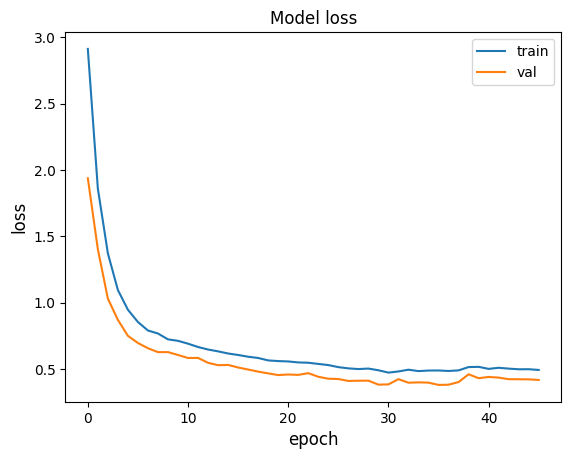

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step


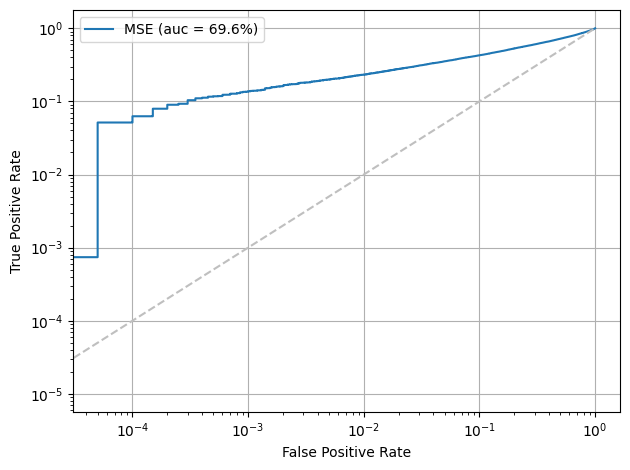

In [ ]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

make_plot_roc_curves(background_test, signal_test)

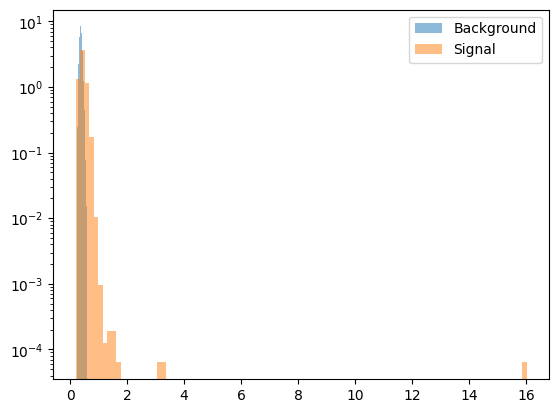

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [ ]:
pretrained_model = Model()
pretrained_model.load()

# Check its architecture
pretrained_model.ae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sinusoidal_positional_en… │ (None, 200, 2)         │              0 │ input_layer_2[0][0]    │
│ (SinusoidalPositionalEnc… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_8    │ (None, 200, 2)         │          1,410 │ sinusoidal_positional… │
│ (MultiHeadAttention)      │                        │                │ sinusoidal_positional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_37 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_28    │ (None, 200, 2)         │              4 │ dropout_37[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_2… │
│                           │                        │                │ sinusoidal_positional… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 200, 64)        │            192 │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_38 (Dropout)      │ (None, 200, 64)        │              0 │ conv1d_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 200, 2)         │            130 │ dropout_38[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_29    │ (None, 200, 2)         │              4 │ conv1d_17[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_25 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_2… │
│                           │                        │                │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_9    │ (None, 200, 2)         │          1,410 │ add_25[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_25[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_40 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_30    │ (None, 200, 2)         │              4 │ dropout_40[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_26 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_3… │
│                      

 Total params: 412,100 (1.57 MB)

 Trainable params: 137,366 (536.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 274,734 (1.05 MB)

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

class Model_Test:
    def __init__(self):
        self.clf = None

    def predict(self, X):
        if self.clf is None:
            raise ValueError("The model is not loaded. Please call the load method first.")
        reconstructed = self.clf.predict(X, batch_size=32)
        reconstruction_error = np.mean((X - reconstructed) ** 2, axis=(1, 2))

        # Use z-score normalization for better anomaly scoring
        mean_err = np.mean(reconstruction_error)
        std_err = np.std(reconstruction_error) + 1e-12
        z_scores = (reconstruction_error - mean_err) / std_err
        probabilities = 1/(1+np.exp(-z_scores))  # logistic transform

        return probabilities

    def load(self):
        self.clf = keras.models.load_model('model.keras', custom_objects={"SinusoidalPositionalEncoding": SinusoidalPositionalEncoding})


In [ ]:
test_model = Model_Test()
test_model.load()

predictions = test_model.predict(x_test)
print(predictions)

!zip -r submission.zip model.py model.keras

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
[0.76268258 0.86436884 0.12840231 ... 0.84100695 0.51306891 0.64702461]
updating: model.py (deflated 51%)
updating: model.keras (deflated 21%)


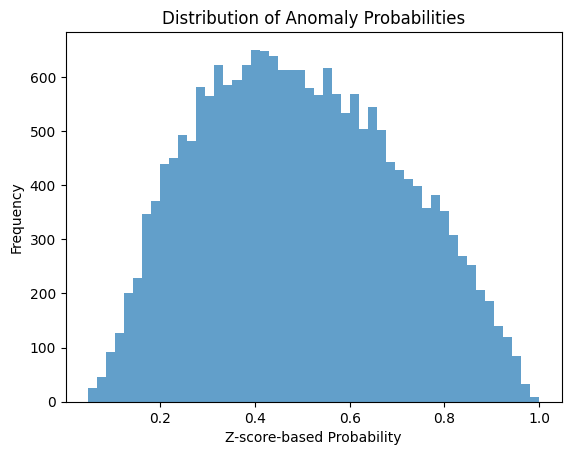

In [ ]:
plt.hist(predictions, bins=50, alpha=0.7)
plt.xlabel("Z-score-based Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Probabilities")
plt.show()